In [1]:
import tensorflow as tf
import sys
sys.path.insert(0, '/home/ading/dev/empirical-mt')
sys.path.insert(0, '/home/ading/dev/pyflow/')

from skimage import io, img_as_ubyte, color, draw
import numpy as np


import matplotlib.pyplot as plt

from visual_tracking.utils import est_contrast_flow_input_pip

import pandas as pd

import numpy as np
import pyflow

import cv2

from tqdm import tqdm

from scipy.stats.stats import pearsonr 

from datetime import datetime
from time import time
import sys

sys.path.insert(0, '/home/ading/dev/empirical-mt')

from visual_tracking.model.alov300_model_omid_mt2 import MTTracker
from visual_tracking.utils.est_contrast_flow_input_pip import EstimatorOpticFlowInputFunc



Using TensorFlow backend.


In [2]:
ne = est_contrast_flow_input_pip.EstimatorOpticFlowInputFunc(dataset_index_filepath='../data/alov300++/alov300_train.csv', input_path='../', fixed_input_dim=76, batch_size=1000, num_epochs=1, cache_path='../', cache_id='eval_shuffled_with_mask_ds', shuffle=False)

In [3]:
model_dir = '../models_e2e/alov300/s=4_07-01-17-29-07'

model_fn = MTTracker(mt_params_path='../params_MT_654.pkl', speed_scaler=4)
m = tf.estimator.Estimator(model_fn, model_dir=model_dir)
   
p = m.predict(input_fn=ne)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c0789af90>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '../models_e2e/alov300/s=4_07-01-17-29-07', '_save_summary_steps': 100}


In [4]:
p_b2 = np.stack(p, axis=0)

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.int32, tf.int32)>
intput pipline initilized, input_shpae=({'box': TensorShape([Dimension(None), Dimension(4)]), 'direction': TensorShape([Dimension(None), Dimension(76), Dimension(76)]), 'mask': TensorShape([Dimension(None), Dimension(76), Dimension(76)]), 'frame2': TensorShape([Dimension(None), Dimension(76), Dimension(76), Dimension(3)]), 'frame1': TensorShape([Dimension(None), Dimension(76), Dimension(76), Dimension(3)]), 'speed': TensorShape([Dimension(None), Dimension(76), Dimension(76)])}, TensorShape([Dimension(None), Dimension(4)])), input_dtype=({'box': tf.float32, 'direction': tf.float32, 'mask': tf.float32, 'frame2': tf.float32, 'frame1': tf.float32, 'speed': tf.float32}, tf.float32)
INFO:tensorflow:Restoring parameters from ../models_e2e/alov300/s=4_07-01-17-29-07/model.ckpt-10677


In [5]:
b1s = []
b2s = []

it = ne()

with tf.Session() as sess:
    i = 1
    while True:
        i = i + 1
        try:
            r = sess.run(it)
        except tf.errors.OutOfRangeError:
            break
        
        for i in tqdm(range(0, r[1].shape[0])):
            
            
            b1 = r[0]['box'][i, :]
            b2 = r[1][i, :]
            
            b1s.append(b1)
            b2s.append(b2)
            
b1s = np.stack(b1s, axis=0)
b2s = np.stack(b2s, axis=0)

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.int32, tf.int32)>
intput pipline initilized, input_shpae=({'box': TensorShape([Dimension(None), Dimension(4)]), 'direction': TensorShape([Dimension(None), Dimension(76), Dimension(76)]), 'mask': TensorShape([Dimension(None), Dimension(76), Dimension(76)]), 'frame2': TensorShape([Dimension(None), Dimension(76), Dimension(76), Dimension(3)]), 'frame1': TensorShape([Dimension(None), Dimension(76), Dimension(76), Dimension(3)]), 'speed': TensorShape([Dimension(None), Dimension(76), Dimension(76)])}, TensorShape([Dimension(None), Dimension(4)])), input_dtype=({'box': tf.float32, 'direction': tf.float32, 'mask': tf.float32, 'frame2': tf.float32, 'frame1': tf.float32, 'speed': tf.float32}, tf.float32)


100%|██████████| 14/14 [00:00<00:00, 9588.55it/s]


In [8]:
def metrics(p_b2, t_b2, b_1):
    p_b2 = p_b2 - b_1
    t_b2 = t_b2 - b_1
    return {
        'l1': np.linalg.norm(p_b2 - t_b2, ord=1) / t_b2.size,
        'l2': np.linalg.norm(p_b2 - t_b2, ord=2) / t_b2.size,
        'cor_v1_x': np.corrcoef(p_b2[:, 1], t_b2[:, 1]), 
        'cor_v1_y': np.corrcoef(p_b2[:, 0], t_b2[:, 0]), 
        'cor_v2_x': np.corrcoef(p_b2[:, 3], t_b2[:, 3]), 
        'cor_v2_y': np.corrcoef(p_b2[:, 2], t_b2[:, 2]), 
    }

In [1]:
metrics(p_b2, b2s, b1s)

NameError: name 'metrics' is not defined

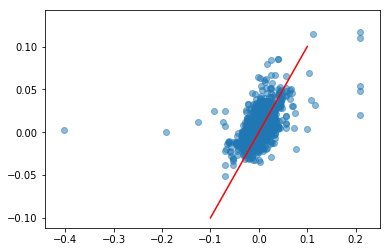

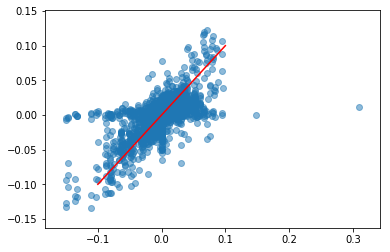

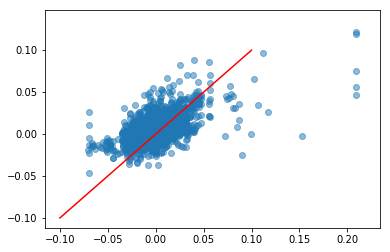

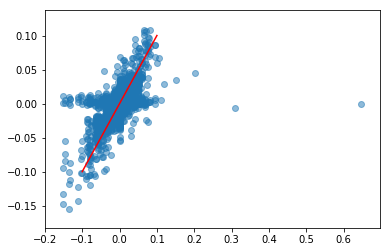

In [22]:
for i in range(0 ,4):
    
    x = np.linspace(-0.1, 0.1, 1000)

    plt.scatter(x=(b2s - b1s)[:, i], y=(p_b2 - b1s)[:, i], alpha=0.5)
    
    plt.plot(x, x, color='r');
    
    
    plt.show()


In [40]:
# do nothing baseline

b1 = df[['b1_v1_y', 'b1_v1_x', 'b1_v2_y', 'b1_v2_x']].values
t_b2 = df[['b2_v1_y', 'b2_v1_x', 'b2_v2_y', 'b2_v2_x']].values
p_b2 = df[['b1_v1_y', 'b1_v1_x', 'b1_v2_y', 'b1_v2_x']].values

metrics(p_b2, t_b2, b1)

{'cor_v1_x': array([[ nan,  nan],
        [ nan,   1.]]), 'cor_v1_y': array([[ nan,  nan],
        [ nan,   1.]]), 'cor_v2_x': array([[ nan,  nan],
        [ nan,   1.]]), 'cor_v2_y': array([[ nan,  nan],
        [ nan,   1.]]), 'l1': 0.0021995590424825268, 'l2': 6.9412195677326765e-05}

In [50]:
# linear regression

from sklearn.linear_model import LinearRegression

m = LinearRegression()

df_train = pd.read_csv('linear_reg_train.csv')

m.fit(X=df_train[['avg_in_x', 'avg_in_y', 'b1_v1_y', 'b1_v1_x', 'b1_v2_y', 'b1_v2_x']], y=df_train[['b2_v1_y', 'b2_v1_x', 'b2_v2_y', 'b2_v2_x']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [53]:
0.004 * 76

0.304

In [52]:
m.coef_

array([[  7.42574995e-05,   4.33361643e-03,   2.05397840e+03,
          2.85520522e+02,   2.05298154e+03,   2.85524766e+02],
       [  5.64588312e-03,  -6.79476060e-05,  -3.83614236e+03,
         -1.52706297e+04,  -3.83613623e+03,  -1.52716309e+04],
       [  6.65796391e-05,   4.30489472e-03,   5.66256975e+02,
         -1.38112694e+03,   5.67261232e+02,  -1.38112155e+03],
       [  5.65425274e-03,  -8.50371916e-05,  -6.32578176e+03,
         -1.53088829e+04,  -6.32577472e+03,  -1.53078831e+04]])

In [48]:
m.intercept_

array([  1.35965093e-05,   5.07794893e-01,   1.01367314e+00,
         5.06193248e-01])

In [49]:
m.normalize

False

In [39]:
p_b2 = m.predict(df[['avg_in_x', 'avg_in_y', 'b1_v1_y', 'b1_v1_x', 'b1_v2_y', 'b1_v2_x']])

metrics(p_b2, t_b2, b1)

{'cor_v1_x': array([[ 1.        ,  0.68703615],
        [ 0.68703615,  1.        ]]),
 'cor_v1_y': array([[ 1.       ,  0.6261611],
        [ 0.6261611,  1.       ]]),
 'cor_v2_x': array([[ 1.        ,  0.64224526],
        [ 0.64224526,  1.        ]]),
 'cor_v2_y': array([[ 1.        ,  0.68217116],
        [ 0.68217116,  1.        ]]),
 'l1': 0.0016578229124489211,
 'l2': 5.312575296138533e-05}